In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor

from scipy.stats import randint, uniform
kpmg_palette = ['#00338D', '#0070C0', '#00A1E0', '#00A2FF', '#C0C0C0']

In [157]:
df = pd.read_csv('Insurance claims data.csv',index_col='policy_id')

In [158]:
data_df = df.copy()

In [159]:
data_df['claim_amount'] = np.where(data_df['claim_status'] == 1, 
                            [random.randint(1005, 123247) for _ in range(len(data_df))], 
                            np.nan)

print(data_df.claim_amount)

policy_id
POL045360   NaN
POL016745   NaN
POL007194   NaN
POL018146   NaN
POL049011   NaN
             ..
POL019269   NaN
POL001254   NaN
POL019859   NaN
POL014061   NaN
POL054184   NaN
Name: claim_amount, Length: 58592, dtype: float64


In [160]:
data_df['claim_amount'] = data_df['claim_amount'].fillna(0)

In [161]:
file_path_export = 'Insurance_claims_data_export(Clm_amount).xlsx'
data_df.to_excel(file_path_export, index=False)

In [162]:
# Retrieve the column names of the DataFrame 'df'
column_names = data_df.columns
# Print the column names
print(column_names)

Index(['subscription_length', 'vehicle_age', 'customer_age', 'region_code',
       'region_density', 'segment', 'State Name', 'Latitude', 'Longitude',
       'model', 'fuel_type', 'airbags', 'is_esc', 'is_adjustable_steering',
       'is_tpms', 'is_parking_sensors', 'is_parking_camera',
       'rear_brakes_type', 'displacement', 'cylinder', 'transmission_type',
       'steering_type', 'turning_radius', 'length', 'width', 'gross_weight',
       'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'claim_status',
       'claim_amount'],
      dtype='object')


In [163]:
shape = data_df.shape
print(shape)

(58592, 41)


In [164]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58592 entries, POL045360 to POL054184
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subscription_length               58592 non-null  float64
 1   vehicle_age                       58592 non-null  float64
 2   customer_age                      58592 non-null  int64  
 3   region_code                       58592 non-null  object 
 4   region_density                    58592 non-null  int64  
 5   segment                           58592 non-null  object 
 6   State Name                        58592 non-null  object 
 7   Latitude                          58592 non-null  float64
 8   Longitude                         58592 non-null  float64
 9   model                             58592 non-null  object 
 10  fuel_type                         58592 non-null  object 
 11  airbags                           58592 non-null  int64  
 1

In [165]:
data_df.duplicated().sum()

1880

In [166]:
data_df.isna().sum().value_counts()

0    41
Name: count, dtype: int64

In [167]:
data_df.duplicated().value_counts()

False    56712
True      1880
Name: count, dtype: int64

In [168]:
data_df.head()

,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,State Name,Latitude,Longitude,model,...,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,claim_amount
policy_id,,,,,,,,,,,,,,,,,,,,,
POL045360,9.3,1.2,41,C8,8794,C2,DADRA AND NAGAR HAVELI,20.266578,73.016618,M4,...,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0,0.0
POL016745,8.2,1.8,35,C2,27003,C1,ANDHRA PRADESH,14.750429,78.570026,M9,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0,0.0
POL007194,9.5,0.2,44,C8,8794,C2,DADRA AND NAGAR HAVELI,20.266578,73.016618,M4,...,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0,0.0
POL018146,5.2,0.4,44,C10,73430,A,GOA,15.491997,73.818001,M1,...,No,No,Yes,No,No,No,Yes,0,0,0.0
POL049011,10.1,1.0,56,C13,5410,B2,JAMMU AND KASHMIR,34.299959,74.466658,M5,...,Yes,Yes,Yes,No,No,Yes,Yes,5,0,0.0


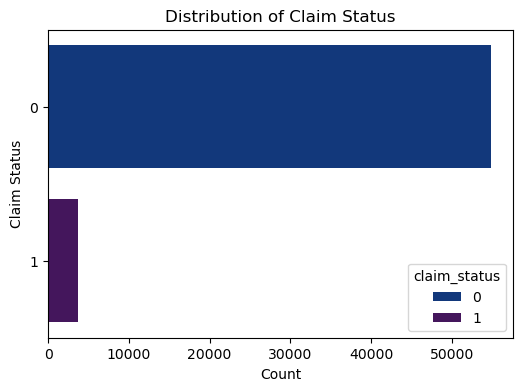

In [169]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, y='claim_status', hue='claim_status', palette=['#00338D', '#470A68'])
plt.xlabel('Count')
plt.ylabel('Claim Status')
plt.title('Distribution of Claim Status')
plt.show()

In [170]:
numerical_columns = data_df[['subscription_length', 'vehicle_age', 'customer_age','region_density','airbags','displacement','cylinder','turning_radius','length','width','gross_weight','ncap_rating']].columns

# Displaying the column names of the selected numerical columns
numerical_columns

Index(['subscription_length', 'vehicle_age', 'customer_age', 'region_density',
       'airbags', 'displacement', 'cylinder', 'turning_radius', 'length',
       'width', 'gross_weight', 'ncap_rating'],
      dtype='object')

In [171]:
data_df.isnull().sum().sum()

0

In [172]:
unique_counts = data_df.nunique()
print(unique_counts)

subscription_length                  140
vehicle_age                           49
customer_age                          41
region_code                           22
region_density                        22
segment                                6
State Name                            22
Latitude                              22
Longitude                             22
model                                 11
fuel_type                              3
airbags                                3
is_esc                                 2
is_adjustable_steering                 2
is_tpms                                2
is_parking_sensors                     2
is_parking_camera                      2
rear_brakes_type                       2
displacement                           9
cylinder                               2
transmission_type                      2
steering_type                          3
turning_radius                         9
length                                 9
width           

In [173]:
data_df.head()

,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,State Name,Latitude,Longitude,model,...,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,claim_amount
policy_id,,,,,,,,,,,,,,,,,,,,,
POL045360,9.3,1.2,41,C8,8794,C2,DADRA AND NAGAR HAVELI,20.266578,73.016618,M4,...,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0,0.0
POL016745,8.2,1.8,35,C2,27003,C1,ANDHRA PRADESH,14.750429,78.570026,M9,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0,0.0
POL007194,9.5,0.2,44,C8,8794,C2,DADRA AND NAGAR HAVELI,20.266578,73.016618,M4,...,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0,0.0
POL018146,5.2,0.4,44,C10,73430,A,GOA,15.491997,73.818001,M1,...,No,No,Yes,No,No,No,Yes,0,0,0.0
POL049011,10.1,1.0,56,C13,5410,B2,JAMMU AND KASHMIR,34.299959,74.466658,M5,...,Yes,Yes,Yes,No,No,Yes,Yes,5,0,0.0


In [174]:
## Adding random claim amoun with a range of 1005 to 123247 for further analysis.

In [175]:
data_df['claim_amount'] = data_df['claim_amount'].fillna(0)

In [176]:
filtered_df = data_df[data_df['claim_status'] == 1]

In [177]:
# Check there are no non-zero values for 'claim_amount' where 'is_claim' = 1
mask = (data_df['claim_amount'] > 0) & (data_df['claim_status'] == 0)
data_df[mask]

,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,State Name,Latitude,Longitude,model,...,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status,claim_amount
policy_id,,,,,,,,,,,,,,,,,,,,,


<Axes: xlabel='claim_amount', ylabel='Count'>

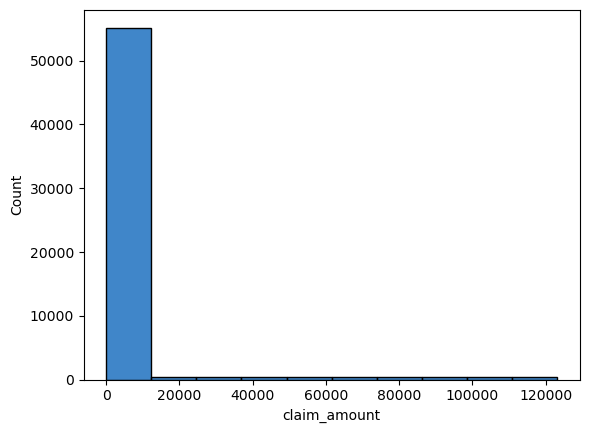

In [178]:
sns.histplot(data_df['claim_amount'], bins=10, color='#005EB8')

In [179]:
# Create clean copy of training data
X = data_df.copy()
y = data_df['claim_status']

# Drop the target feature
X.drop(columns=['claim_amount','claim_status'], inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [180]:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(train_ratio)
print(test_ratio)

6.4
6.37


In [181]:
X_train.head()

,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,State Name,Latitude,Longitude,model,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
policy_id,,,,,,,,,,,,,,,,,,,,,
POL002911,1.6,3.0,40,C7,6112,B2,CHHATTISGARH,22.090420,82.159987,M5,...,No,No,Yes,Yes,Yes,No,No,Yes,Yes,5
POL014754,10.0,1.6,37,C5,34738,C1,BIHAR,25.785414,87.479973,M9,...,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4
POL045499,2.2,2.2,49,C8,8794,B2,DADRA AND NAGAR HAVELI,20.266578,73.016618,M6,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
POL040493,0.1,0.8,53,C5,34738,C2,BIHAR,25.785414,87.479973,M4,...,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3
POL001288,0.4,1.4,48,C8,8794,B2,DADRA AND NAGAR HAVELI,20.266578,73.016618,M6,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2


In [182]:
y_test.head()

policy_id
POL001548    0
POL006059    0
POL011391    0
POL026684    0
POL042723    0
Name: claim_status, dtype: int64

In [183]:
# Create a new copy of X_train for the analysis
eda_test_data = X_train.copy()
eda_test_data['claim_status'] = y_train

In [184]:
## All values where there are 2 nUnique values are now Binary Cols

In [185]:
binary_cols=X_train.columns[X_train.nunique() == 2]
print(binary_cols)

Index(['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'cylinder',
       'transmission_type', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert'],
      dtype='object')


In [186]:
# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
           'Disc': 1,
           'Drum': 0,
           'Automatic': 1,
           'Manual': 0,
           'Electric': 1,
           'Power': 0}

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)

In [187]:
## Dropping value "Cylinder" as it is a numerical value

In [188]:
eda_test_data.drop(columns=['cylinder',], inplace=True)

In [189]:
eda_test_data.corr(numeric_only=True).sort_values(by='claim_status',ascending=False)

,subscription_length,vehicle_age,customer_age,region_density,Latitude,Longitude,airbags,is_esc,is_adjustable_steering,is_tpms,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
claim_status,0.081883,-0.030352,0.021380,-0.015625,-0.004263,0.004428,0.001343,0.001318,0.014362,-0.001915,...,0.010448,0.005672,0.005672,0.000882,0.010322,0.009682,0.005672,0.009195,0.001974,1.000000
subscription_length,1.000000,0.162514,0.143864,-0.097198,0.005645,-0.140057,0.103513,0.105210,0.190952,0.093538,...,0.181977,0.225284,0.225284,0.008794,0.189339,0.113873,0.225284,-0.008779,0.170402,0.081883
customer_age,0.143864,-0.036175,1.000000,0.008827,0.004121,-0.027822,-0.007645,-0.013672,0.012733,-0.001409,...,0.027379,-0.040191,-0.040191,0.023005,0.012819,0.001963,-0.040191,0.002327,-0.032476,0.021380
is_adjustable_steering,0.190952,0.367881,0.012733,-0.092292,-0.028610,-0.227288,0.522686,0.518432,1.000000,0.451751,...,0.864695,0.764924,0.764924,0.180788,0.932308,0.461840,0.764924,0.096846,0.646226,0.014362
is_front_fog_lights,0.187572,0.348155,0.013159,-0.093481,-0.028709,-0.220330,0.551165,0.550054,0.945626,0.477728,...,0.916106,0.723331,0.723331,0.170958,0.987623,0.499916,0.723331,0.091580,0.511874,0.011746
is_brake_assist,0.181977,0.350106,0.027379,-0.092791,-0.027246,-0.215929,0.584239,0.612798,0.864695,0.507805,...,1.000000,0.680488,0.680488,0.160832,0.929126,0.393950,0.680488,-0.070754,0.419225,0.010448
is_driver_seat_height_adjustable,0.189339,0.355912,0.012819,-0.093107,-0.028769,-0.221130,0.544675,0.569367,0.932308,0.471815,...,0.929126,0.732396,0.732396,0.173101,1.000000,0.491303,0.732396,-0.065739,0.541649,0.010322
is_parking_sensors,-0.013063,-0.022394,0.031245,-0.008181,0.002843,0.016951,0.126952,0.138571,0.254186,0.114829,...,0.226128,-0.126369,-0.126369,-0.029867,0.243377,-0.261513,-0.126369,-0.015999,-0.035547,0.009740
is_day_night_rear_view_mirror,0.113873,0.191765,0.001963,-0.039248,-0.015553,-0.135095,-0.260819,-0.224665,0.461840,-0.439095,...,0.393950,0.483223,0.483223,0.114209,0.491303,1.000000,0.483223,0.061180,0.094750,0.009682
is_speed_alert,-0.008779,-0.044723,0.002327,-0.003587,0.000013,0.002213,0.048369,-0.115460,0.096846,0.043750,...,-0.070754,-0.048147,-0.048147,-0.011379,-0.065739,0.061180,-0.048147,1.000000,-0.182381,0.009195


<Axes: >

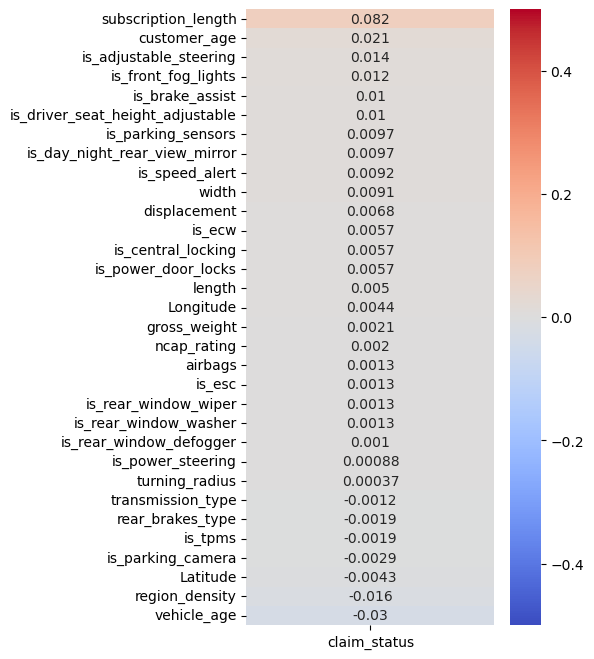

In [190]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='claim_status',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('claim_status')

sns.heatmap(corr_matrix_no_claim[['claim_status']],cmap='coolwarm', annot=True, vmax=0.5, vmin=-0.5)

In [191]:
eda_test_data.head()

,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,State Name,Latitude,Longitude,model,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
policy_id,,,,,,,,,,,,,,,,,,,,,
POL002911,1.6,3.0,40,C7,6112,B2,CHHATTISGARH,22.090420,82.159987,M5,...,0,1,1,1,0,0,1,1,5,0
POL014754,10.0,1.6,37,C5,34738,C1,BIHAR,25.785414,87.479973,M9,...,0,1,1,1,1,1,1,1,4,0
POL045499,2.2,2.2,49,C8,8794,B2,DADRA AND NAGAR HAVELI,20.266578,73.016618,M6,...,1,1,1,1,1,1,1,1,2,0
POL040493,0.1,0.8,53,C5,34738,C2,BIHAR,25.785414,87.479973,M4,...,1,1,1,1,1,0,1,1,3,0
POL001288,0.4,1.4,48,C8,8794,B2,DADRA AND NAGAR HAVELI,20.266578,73.016618,M6,...,1,1,1,1,1,1,1,1,2,0


In [192]:
X_train_raw = X_train.copy()

cols_to_drop = [
    'is_rear_window_defogger','turning_radius','rear_brakes_type','Longitude','Latitude']

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)

In [193]:
## Cheking for NUll Values

In [194]:
# Check the number of missing values in each row
X_train_raw.isnull().sum()

subscription_length                 0
vehicle_age                         0
customer_age                        0
region_code                         0
region_density                      0
segment                             0
State Name                          0
model                               0
fuel_type                           0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
displacement                        0
cylinder                            0
transmission_type                   0
steering_type                       0
length                              0
width                               0
gross_weight                        0
is_front_fog_lights                 0
is_rear_window_wiper                0
is_rear_window_washer               0
is_brake_assist                     0
is_power_doo

In [195]:
cat_columns = [
    'region_code','segment', 'State Name', 'model', 
    'fuel_type','is_esc', 
    'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera','transmission_type', 'steering_type',
    'is_front_fog_lights','is_rear_window_wiper','is_rear_window_washer',
    'is_brake_assist','is_power_door_locks','is_central_locking','is_power_steering','is_driver_seat_height_adjustable',
    'is_day_night_rear_view_mirror','is_ecw','is_speed_alert']


X_train_raw[cat_columns] = X_train_raw[cat_columns].astype('category')


In [196]:
policy_id_index  = X_train_raw.index

In [197]:
# Define ordinal features
cat_cols_bin = ['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
                'is_parking_camera','is_brake_assist', 'is_power_door_locks',
                'is_central_locking', 'is_power_steering','is_front_fog_lights','is_rear_window_wiper','is_rear_window_washer',
                'is_driver_seat_height_adjustable','is_day_night_rear_view_mirror','is_ecw','is_speed_alert']

cat_cols_one_hot = ['model','fuel_type','steering_type','transmission_type']

In [198]:
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

In [199]:
bin_encoder = OrdinalEncoder()
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [200]:
bin_encoded = bin_encoder.fit_transform(X_train_raw[cat_cols_bin])
one_hot_encoded = one_hot_encoder.fit_transform(X_train_raw[cat_cols_one_hot])

In [201]:
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, index=policy_id_index, columns=one_hot_encoder.get_feature_names_out(cat_cols_one_hot))
bin_encoded_df = pd.DataFrame(bin_encoded, index=policy_id_index,columns=bin_encoder.get_feature_names_out(cat_cols_bin))


In [202]:
bin_encoded_df

,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
policy_id,,,,,,,,,,,,,,,,
POL002911,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
POL014754,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
POL045499,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
POL040493,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
POL001288,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POL010274,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
POL036063,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
POL031765,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [203]:
# # Assuming bin_encoded is a DataFrame and contains a 'policy_id' column
# bin_encoded_df = pd.DataFrame(bin_encoded).set_index('index''policy_id')
# bin_encoded_df.columns = cat_cols_bin

# # Assuming one_hot_encoded contains 'policy_id' as well
# one_hot_encoded_df = pd.DataFrame(one_hot_encoded).set_index('policy_id')

In [204]:
bin_encoded

array([[0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.]])

In [205]:
# # Assuming bin_encoded is a DataFrame and contains a 'policy_id' column
# bin_encoded_df = pd.DataFrame(bin_encoded, index=bin_encoded.policy_id)
# bin_encoded_df.columns = cat_cols_bin
# one_hot_encoded_df = pd.DataFrame(one_hot_encoded, index=bin_encoded.policy_id)


In [206]:
all_cat_encoded_df = pd.concat([bin_encoded_df,one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_front_fog_lights,...,model_M8,model_M9,fuel_type_CNG,fuel_type_Diesel,fuel_type_Petrol,steering_type_Electric,steering_type_Manual,steering_type_Power,transmission_type_Automatic,transmission_type_Manual
policy_id,,,,,,,,,,,,,,,,,,,,,
POL002911,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
POL014754,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
POL045499,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
POL040493,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
POL001288,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [207]:
numerical_cols_df.isnull().sum()

subscription_length    0
vehicle_age            0
customer_age           0
region_density         0
airbags                0
displacement           0
cylinder               0
length                 0
width                  0
gross_weight           0
ncap_rating            0
dtype: int64

In [208]:
X_train_cleaned = pd.concat([all_cat_encoded_df, numerical_cols_df], axis =1)

In [209]:
print(numerical_cols_df.index)

Index(['POL002911', 'POL014754', 'POL045499', 'POL040493', 'POL001288',
       'POL018605', 'POL013311', 'POL049385', 'POL039849', 'POL009653',
       ...
       'POL041842', 'POL014243', 'POL011257', 'POL049405', 'POL038127',
       'POL010274', 'POL036063', 'POL031765', 'POL008369', 'POL048902'],
      dtype='object', name='policy_id', length=46873)


In [210]:
# Assuming df is your DataFrame
df_index = numerical_cols_df.index
print(df_index)

Index(['POL002911', 'POL014754', 'POL045499', 'POL040493', 'POL001288',
       'POL018605', 'POL013311', 'POL049385', 'POL039849', 'POL009653',
       ...
       'POL041842', 'POL014243', 'POL011257', 'POL049405', 'POL038127',
       'POL010274', 'POL036063', 'POL031765', 'POL008369', 'POL048902'],
      dtype='object', name='policy_id', length=46873)


In [211]:
# Check df
X_train_cleaned.head()

,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_front_fog_lights,...,vehicle_age,customer_age,region_density,airbags,displacement,cylinder,length,width,gross_weight,ncap_rating
policy_id,,,,,,,,,,,,,,,,,,,,,
POL002911,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,3.0,40,6112,2,1497,4,3990,1755,1490,5
POL014754,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.6,37,34738,2,1498,4,3995,1695,1051,4
POL045499,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.2,49,8794,2,1197,4,3845,1735,1335,2
POL040493,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.8,53,34738,6,1493,4,4300,1790,1720,3
POL001288,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.4,48,8794,2,1197,4,3845,1735,1335,2


In [212]:
X_train_cleaned.isnull().sum()

is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
is_brake_assist                     0
is_power_door_locks                 0
is_central_locking                  0
is_power_steering                   0
is_front_fog_lights                 0
is_rear_window_wiper                0
is_rear_window_washer               0
is_driver_seat_height_adjustable    0
is_day_night_rear_view_mirror       0
is_ecw                              0
is_speed_alert                      0
model_M1                            0
model_M10                           0
model_M11                           0
model_M2                            0
model_M3                            0
model_M4                            0
model_M5                            0
model_M6                            0
model_M7                            0
model_M8                            0
model_M9    

In [213]:
X_train_cleaned.head()

,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_front_fog_lights,...,vehicle_age,customer_age,region_density,airbags,displacement,cylinder,length,width,gross_weight,ncap_rating
policy_id,,,,,,,,,,,,,,,,,,,,,
POL002911,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,3.0,40,6112,2,1497,4,3990,1755,1490,5
POL014754,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.6,37,34738,2,1498,4,3995,1695,1051,4
POL045499,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.2,49,8794,2,1197,4,3845,1735,1335,2
POL040493,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.8,53,34738,6,1493,4,4300,1790,1720,3
POL001288,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.4,48,8794,2,1197,4,3845,1735,1335,2


In [214]:
X_train_encoded = pd.get_dummies(X_train_cleaned, drop_first=True)

In [215]:
X_train_cleaned.corr(numeric_only=True)

,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_front_fog_lights,...,vehicle_age,customer_age,region_density,airbags,displacement,cylinder,length,width,gross_weight,ncap_rating
is_esc,1.000000,0.518432,0.828666,0.138571,0.845417,0.612798,0.417002,0.417002,0.098558,0.550054,...,0.225845,-0.013672,-0.062119,0.940626,0.661279,0.494691,0.817037,0.650391,0.832176,0.361581
is_adjustable_steering,0.518432,1.000000,0.451751,0.254186,0.450327,0.864695,0.764924,0.764924,0.180788,0.945626,...,0.367881,0.012733,-0.092292,0.522686,0.851865,0.956956,0.821125,0.928151,0.571401,0.646226
is_tpms,0.828666,0.451751,1.000000,0.114829,0.700569,0.507805,0.345555,0.345555,0.081671,0.477728,...,0.195073,-0.001409,-0.059768,0.876469,0.696517,0.432306,0.809462,0.589246,0.883859,0.501123
is_parking_sensors,0.138571,0.254186,0.114829,1.000000,-0.256196,0.226128,-0.126369,-0.126369,-0.029867,0.240365,...,-0.022394,0.031245,-0.008181,0.126952,0.125692,0.265619,0.078540,0.170431,0.222231,-0.035547
is_parking_camera,0.845417,0.450327,0.700569,-0.256196,1.000000,0.410171,0.493250,0.493250,0.116579,0.489410,...,0.226229,-0.040585,-0.055185,0.797812,0.671717,0.420566,0.779956,0.565063,0.585605,0.477756
is_brake_assist,0.612798,0.864695,0.507805,0.226128,0.410171,1.000000,0.680488,0.680488,0.160832,0.916106,...,0.350106,0.027379,-0.092791,0.584239,0.678479,0.826146,0.753870,0.871653,0.664236,0.419225
is_power_door_locks,0.417002,0.764924,0.345555,-0.126369,0.493250,0.680488,1.000000,1.000000,0.236348,0.723331,...,0.434410,-0.040191,-0.101731,0.407455,0.778681,0.703062,0.768503,0.881758,0.510319,0.782052
is_central_locking,0.417002,0.764924,0.345555,-0.126369,0.493250,0.680488,1.000000,1.000000,0.236348,0.723331,...,0.434410,-0.040191,-0.101731,0.407455,0.778681,0.703062,0.768503,0.881758,0.510319,0.782052
is_power_steering,0.098558,0.180788,0.081671,-0.029867,0.116579,0.160832,0.236348,0.236348,1.000000,0.170958,...,-0.021187,0.023005,-0.000564,0.169860,-0.018498,-0.112443,0.082080,0.256508,-0.085697,0.184837
is_front_fog_lights,0.550054,0.945626,0.477728,0.240365,0.489410,0.916106,0.723331,0.723331,0.170958,1.000000,...,0.348155,0.013159,-0.093481,0.551165,0.774318,0.904923,0.788135,0.878181,0.538522,0.511874


In [216]:
X_train_cleaned = sm.add_constant(X_train_cleaned) 

# Step 2: Fit the model (for a logistic regression, use Binomial family)

glm_model = sm.GLM(y_train, X_train_cleaned, family=sm.families.Binomial())  # Use Gaussian() or Poisson() if needed
glm_results = glm_model.fit()

# Step 3: Check the model summary
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           claim_status   No. Observations:                46873
Model:                            GLM   Df Residuals:                    46858
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10931.
Date:                Sun, 15 Sep 2024   Deviance:                       21862.
Time:                        21:49:57   Pearson chi2:                 4.66e+04
No. Iterations:                    23   Pseudo R-squ. (CS):           0.009469
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [217]:
## We can summarise from the above results that is_parking_camera, Is Power Door Locks and NCAP Rating are not statisticalls relevant.

In [218]:
import statsmodels.api as sm

# List of non-significant columns to drop
non_significant_columns = [
    'is_esc', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_brake_assist', 
    'is_power_door_locks', 'is_central_locking', 'is_rear_window_wiper', 'is_rear_window_washer', 
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert', 
    'model_M1', 'model_M3', 'model_M4', 'model_M6', 'model_M7', 'model_M8', 'fuel_type_CNG', 
    'fuel_type_Diesel', 'fuel_type_Petrol', 'steering_type_Power', 'customer_age', 'width', 
    'gross_weight', 'ncap_rating', 'airbags'
]

# Step 1: Drop the non-significant columns from X_train_cleaned
X_train_cleaned_dropped = X_train_cleaned.drop(columns=non_significant_columns)

# Step 2: Refit the GLM model
# Add a constant (intercept term)
X_train_cleaned_dropped = sm.add_constant(X_train_cleaned_dropped)

# Fit the GLM model again using the cleaned dataset
glm_model_updated = sm.GLM(y_train, X_train_cleaned_dropped, family=sm.families.Binomial())
glm_results_updated = glm_model_updated.fit()

# Step 3: Display the summary of the new GLM model
print(glm_results_updated.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:           claim_status   No. Observations:                46873
Model:                            GLM   Df Residuals:                    46859
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10932.
Date:                Sun, 15 Sep 2024   Deviance:                       21863.
Time:                        21:49:57   Pearson chi2:                 4.67e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.009433
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [219]:
import numpy as np

# Predict probabilities on the test data
y_pred_prob = glm_results.predict(X_train_cleaned)

# Convert probabilities to class labels (0 or 1) using a threshold (default is 0.5)
y_pred = np.where(y_pred_prob >= 0.5, 1, 0)


In [220]:
# Define the classifiers to test
clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42))
]

In [221]:
# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv=kf)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Classifiers')

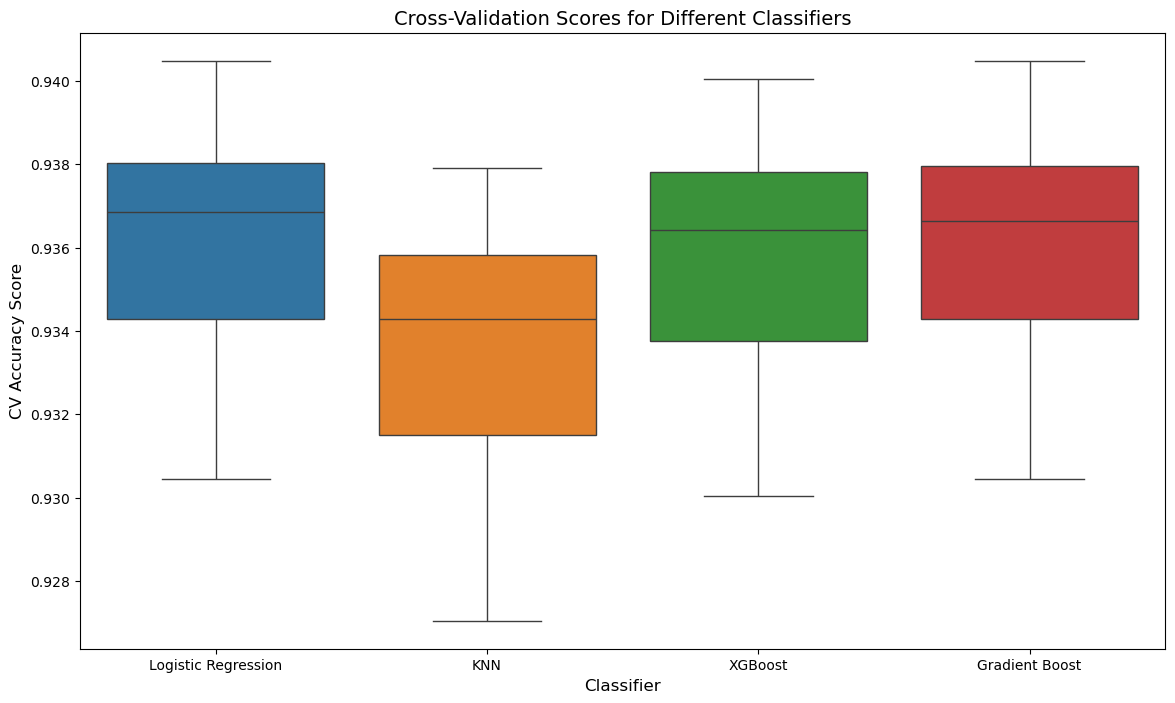

In [222]:
# Plot scores
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize=14)

In [223]:
skewed_features = ['customer_age', 'vehicle_age', 'region_density']

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_cleaned, skewed_features)

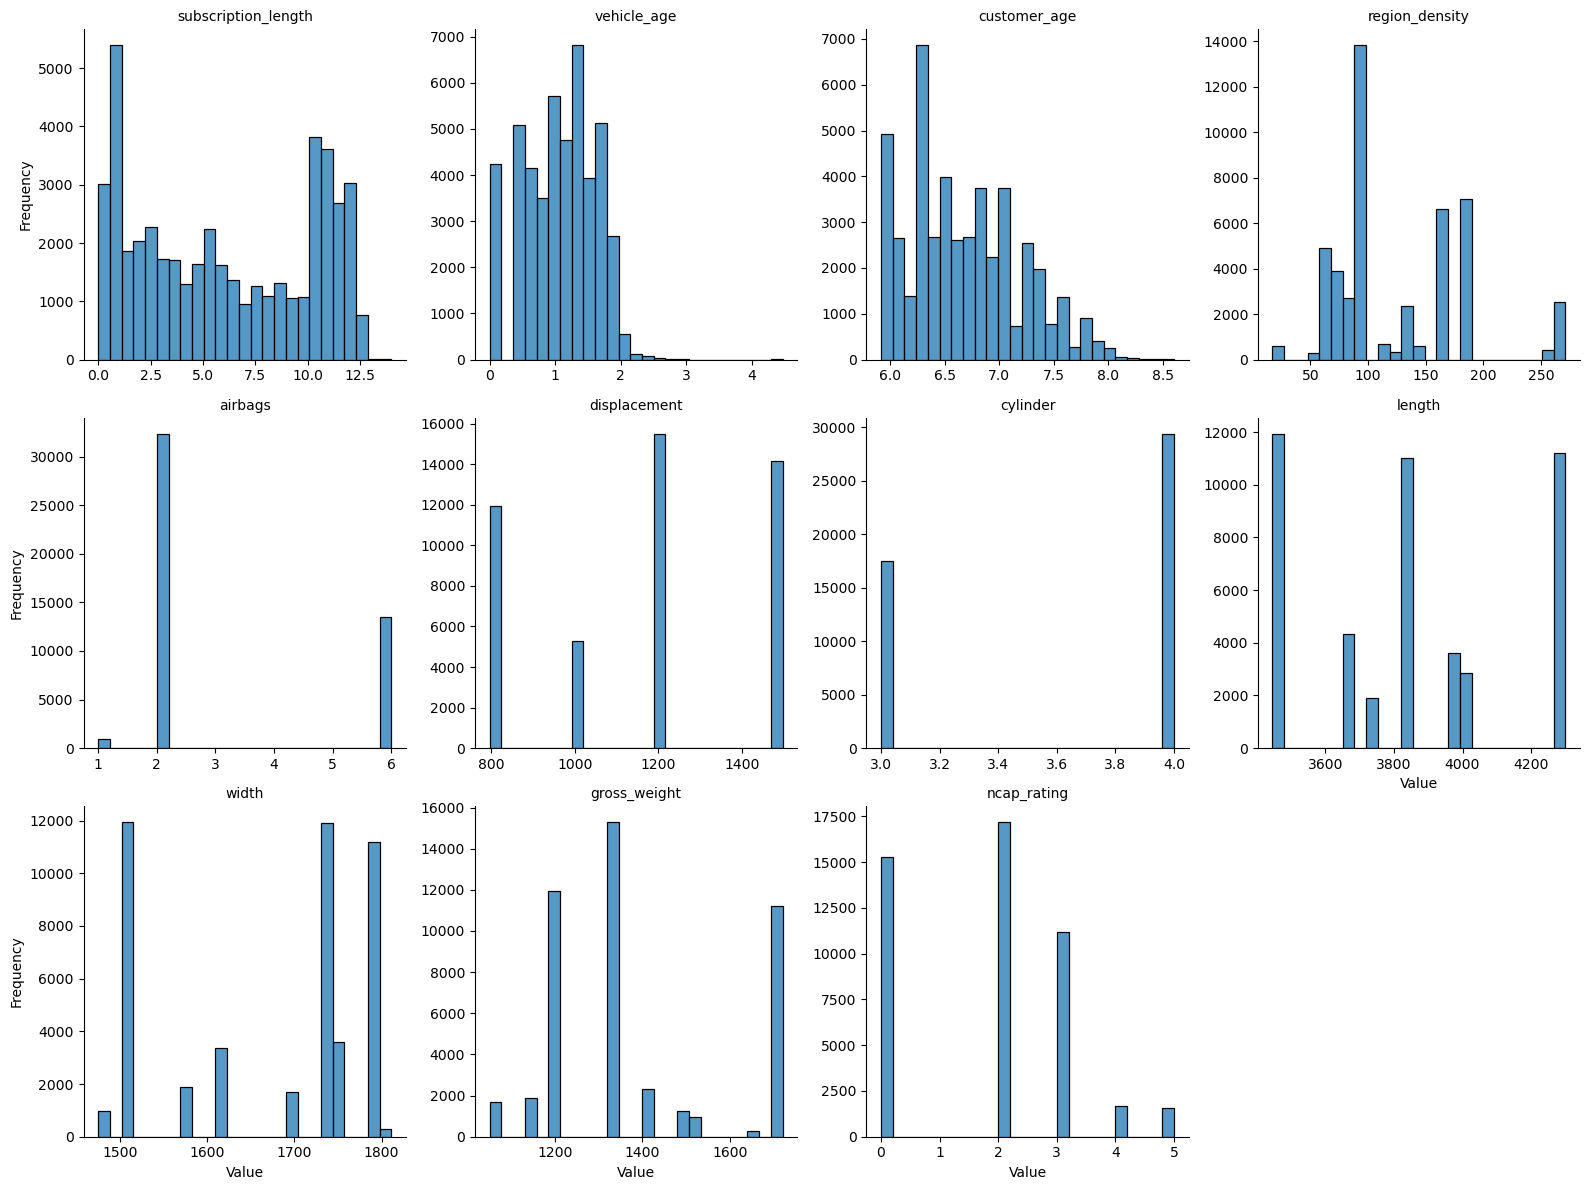

In [224]:
melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

In [225]:
X_train_cleaned_log = sm.add_constant(X_train_cleaned) 

# Step 2: Fit the model (for a logistic regression, use Binomial family)

glm_model = sm.GLM(y_train, X_train_cleaned, family=sm.families.Binomial())  # Use Gaussian() or Poisson() if needed
glm_results = glm_model.fit()

# Step 3: Check the model summary
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           claim_status   No. Observations:                46873
Model:                            GLM   Df Residuals:                    46858
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10931.
Date:                Sun, 15 Sep 2024   Deviance:                       21862.
Time:                        21:51:00   Pearson chi2:                 4.66e+04
No. Iterations:                    23   Pseudo R-squ. (CS):           0.009469
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [226]:
# AIC (Akaike Information Criterion)
aic = glm_results.aic
print(f'AIC: {aic}')

AIC: 21891.51152484925


In [227]:
import statsmodels.api as sm

# List of non-significant columns to drop
non_significant_columns = [
    'is_esc', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_brake_assist', 
    'is_power_door_locks', 'is_central_locking', 'is_rear_window_wiper', 'is_rear_window_washer', 
    'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert', 
    'model_M1', 'model_M3', 'model_M4', 'model_M6', 'model_M7', 'model_M8', 'fuel_type_CNG', 
    'fuel_type_Diesel', 'fuel_type_Petrol', 'steering_type_Power', 'customer_age', 'width', 
    'gross_weight', 'ncap_rating', 'airbags'
]

# Step 1: Drop the non-significant columns from X_train_cleaned
X_train_cleaned_dropped = X_train_cleaned.drop(columns=non_significant_columns)

# Step 2: Refit the GLM model
# Add a constant (intercept term)
X_train_cleaned_dropped = sm.add_constant(X_train_cleaned_dropped)

# Fit the GLM model again using the cleaned dataset
glm_model_updated = sm.GLM(y_train, X_train_cleaned_dropped, family=sm.families.Binomial())
glm_results_updated = glm_model_updated.fit()

# Step 3: Display the summary of the new GLM model
print(glm_results_updated.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           claim_status   No. Observations:                46873
Model:                            GLM   Df Residuals:                    46859
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10932.
Date:                Sun, 15 Sep 2024   Deviance:                       21863.
Time:                        21:51:01   Pearson chi2:                 4.67e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.009433
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [228]:
# Exporting the GLM results to a spreadsheet
# First, we convert the GLM summary to a dataframe format, then export to Excel

# Extract the GLM summary as a string
glm_summary_str = glm_results_updated.summary().as_text()

# Split the summary string into lines and create a list
glm_summary_list = glm_summary_str.splitlines()

# Create a DataFrame to hold the GLM summary
glm_summary_df = pd.DataFrame(glm_summary_list, columns=['GLM Summary'])

# Export the GLM summary DataFrame to an Excel file
file_path_glm_export = 'GLM_Model_Summary.xlsx'
glm_summary_df.to_excel(file_path_glm_export, index=False)

file_path_glm_export

'GLM_Model_Summary.xlsx'

In [229]:
# AIC (Akaike Information Criterion)
aic = glm_results_updated.aic
print(f'AIC: {aic}')

AIC: 21891.227738990226


In [230]:
## The AIC value is smaller than that of the above model, which is why it is better.

In [231]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_log.mean()}')

CV score without log transform: 0.9355279671242294
CV score with log transform: 0.9355279671242294
